In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Arrival data.csv")
hourly_wage = 15
kiosk_cost = 6000

In [12]:
df = df.iloc[:,:4]
df

,Week,Day,Arrival,Adjusted Arrival
0,1,Weekday,08:01:26,00:01:26
1,1,Weekday,08:06:59,00:06:59
2,1,Weekday,08:11:07,00:11:07
3,1,Weekday,08:13:08,00:13:08
4,1,Weekday,08:13:56,00:13:56
...,...,...,...,...
42066,8,Sun,00:52:20,16:52:20
42067,8,Sun,00:53:12,16:53:12
42068,8,Sun,00:55:38,16:55:38
42069,8,Sun,00:58:41,16:58:41


In [4]:
weekday = df[df['Day']=='Weekday']
saturday = df[df['Day']=='Sat']
sunday = df[df['Day']=='Sun']

In [23]:
def DataManip(data):
    data['Arrival'] = pd.to_timedelta(data['Arrival'].astype(str))

    # Subtract 8 hours from each time to adjust the range from 0 to 17 hours
    data['Adjusted Arrival'] = data['Arrival'] - pd.Timedelta(hours=8)
    data['Adjusted Arrival'] = data['Adjusted Arrival'].apply(
        lambda x: x + pd.Timedelta(days=1) if x.total_seconds() < 0 else x)
    return data

# Function to calculate interarrival times
def calculate_interarrival(group):
    # Shift the 'Adjusted Arrival' column to get the difference with the previous row
    interarrival = group['Adjusted Arrival'].diff()

    # For the first row of each group, use the 'Adjusted Arrival' time itself
    interarrival.iloc[0] = group['Adjusted Arrival'].iloc[0]

    # Convert interarrival times to seconds
    return interarrival.dt.total_seconds()

weekday = DataManip(weekday)
weekday['Interarrival Time (sec)'] = weekday.groupby('Week ').apply(calculate_interarrival).reset_index(level=0, drop=True)

saturday = DataManip(saturday)
saturday['Interarrival Time (sec)'] = saturday.groupby('Week ').apply(calculate_interarrival).reset_index(level=0, drop=True)

sunday = DataManip(sunday)
sunday['Interarrival Time (sec)'] = sunday.groupby('Week ').apply(calculate_interarrival).reset_index(level=0, drop=True)


C:\Users\nbeij\AppData\Local\Temp\ipykernel_24188\4257266875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Arrival'] = pd.to_timedelta(data['Arrival'].astype(str))
C:\Users\nbeij\AppData\Local\Temp\ipykernel_24188\4257266875.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Adjusted Arrival'] = data['Arrival'] - pd.Timedelta(hours=8)
C:\Users\nbeij\AppData\Local\Temp\ipykernel_24188\4257266875.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [38]:
saturday[saturday['Week ']==2]

,Week,Day,Arrival,Adjusted Arrival,Interarrival Time (sec)
15428,2,Sat,0 days 08:00:41,0 days 00:00:41,41.0
15429,2,Sat,0 days 08:01:27,0 days 00:01:27,46.0
15430,2,Sat,0 days 08:04:42,0 days 00:04:42,195.0
15431,2,Sat,0 days 08:10:39,0 days 00:10:39,357.0
15432,2,Sat,0 days 08:12:06,0 days 00:12:06,87.0
...,...,...,...,...,...
17199,2,Sat,0 days 00:56:48,0 days 16:56:48,50.0
17200,2,Sat,0 days 00:59:05,0 days 16:59:05,137.0
17201,2,Sat,0 days 00:59:18,0 days 16:59:18,13.0
17202,2,Sat,0 days 00:59:23,0 days 16:59:23,5.0


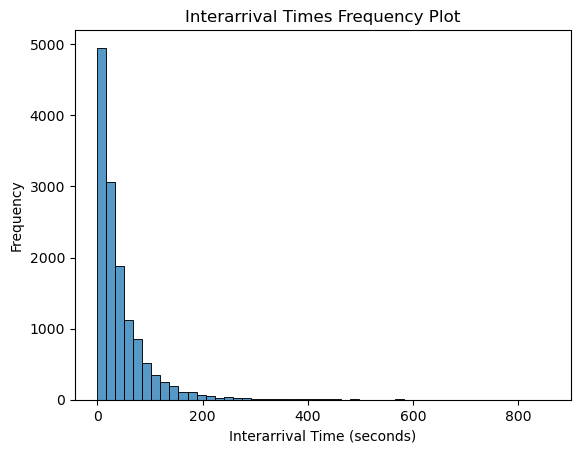

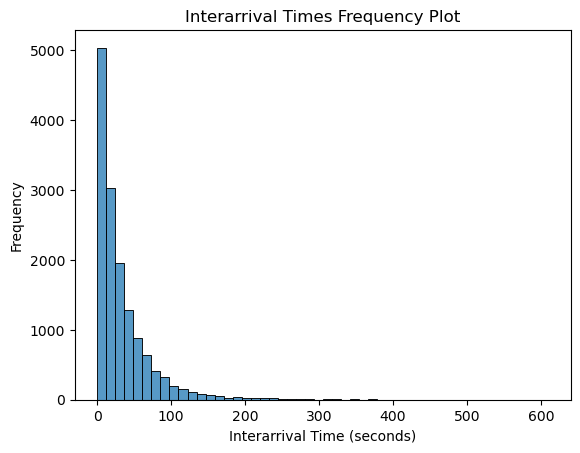

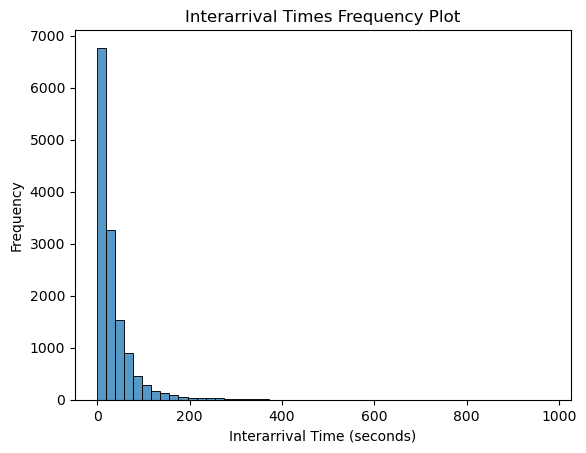

In [39]:
# Plotting
for d in [weekday,saturday,sunday]:
    sns.histplot(d['Interarrival Time (sec)'],bins=50)
    plt.xlabel('Interarrival Time (seconds)')
    plt.ylabel('Frequency')
    plt.title('Interarrival Times Frequency Plot')
    plt.show()